# Getting started with Kinesis


In this notebook, we will generate a mock cluster, observe (add noise) and fit to see if we recover the true parameters of its internal kinematics.

Notes on dependences
- [gapipes](https://github.com/smoh/gapipes): for custom pandas accessor `g` to get covariance matrices, astropy coordinate objects..
- [arviz](https://github.com/arviz-devs/arviz): for visualization

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import numpy as np
import astropy.units as u
import astropy.coordinates as coords
import arviz as az

# project dependencies
import gapipes as gp
import kinesis as kn

In [19]:
plt.style.use(['science','high-contrast','no-latex','notebook'])

In [6]:
np.random.seed(18324)

## Making and observing a mock cluster

First, let's make a cluster with some fiducial parameters.

In [7]:
N = 150  # number of sources
b0 = np.array([17.7, 41.2, 13.3])    # pc
v0 = np.array([-6.32, 45.24, 5.30])  # [vx, vy, vz] in km/s
sigv = 1.  # dispersion, km/s

cl = kn.Cluster(v0, sigv, b0=b0)
cl

Cluster(b0=[17.7 41.2 13.3], v0=[-6.32 45.24  5.3 ], sigmav=1.0)

The cluster currently has no members. We need to 'sample' the cluster in order to populate it. There are two methods for sampling a cluster:
- sample_sphere: sampling uniformly within a maximum radius
- sample_at: sample at exactly the positions you want by giving it astropy coordinates.

Let's do uniform sphere for now. All normal methods of `Cluster` will return itself with modified attributes for method chaining.
Sampling will modify its `members` from `None` to an instance of `ClusterMembers`.

In [8]:
cl.sample_sphere(N=N, Rmax=5)
cl.members

There are two Gaia-like DataFrame associated with `ClusterMembers`:
- `truth`: this is the noise-free Gaia data consistent with the `Cluster`'s internal motions
- `observed`: this is the noise-added Gaia data. If the `ClusterMembers` has not been `observe`d, it will be `None`.

Now let's `observe` the cluster. In order to observe, you need to specify the 3x3 covariance matrix for (parallax, pmra, pmdec) with `cov` keyword. If `cov` is (3,3) array, this will be assumed for all stars. You can also specify different covariance matrix for different stars by specifying `cov` to be (N, 3, 3) array. The noise model is assumed to be Gaussian.

It is also possible to specify covariance by giving another Gaia-like data frame using `error_from` keyword. The following columns needed to construct to covariance matrix are expected: `parallax_error`, `pmra_error`, `pmdec_error`, `parallax_pmra_corr`, `parallax_pmdec_corr`, `pmra_pmdec_corr`. This is useful, for example, if you want to simulate data as noisy as the actual Gaia data you want to model.

Radial velocity errors should be specified separately with `rv_error` keyword, which should be 1-d array with `N` elements, each specifying the Gaussian standard deviation in km/s. If any element in `rv_error` is `np.nan`, it is assumed that the star does not have RV measurement.

This will add noise to the astrometry and radial velocities of the cluster members, and the noise-added Gaia-like data frame is now accessible with `cl.members.observed`.

Let's specify simply 0.01 mas or mas/yr errors for parallax and pmra/pmdec and no available RVs.

In [9]:
cl.observe(cov=np.eye(3)*0.01)

Cluster(b0=[17.7 41.2 13.3], v0=[-6.32 45.24  5.3 ], sigmav=1.0)

Now we have a Gaia-like data in pandas DataFrame in `cl.members.observed`:

In [10]:
cl.members.observed.head()

,ra,dec,parallax,pmra,pmdec,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,parallax_error,pmra_error,pmdec_error
0,69.827908,15.519434,21.594203,100.148848,-26.160099,0.0,0.0,0.0,0.1,0.1,0.1
1,63.449065,18.338080,20.866021,116.734043,-26.047054,0.0,0.0,0.0,0.1,0.1,0.1
2,67.364160,20.868653,21.474773,97.400167,-43.817789,0.0,0.0,0.0,0.1,0.1,0.1
3,62.220135,16.061914,20.065537,116.387176,-26.138049,0.0,0.0,0.0,0.1,0.1,0.1
4,61.149763,17.653502,22.384763,125.056344,-28.292826,0.0,0.0,0.0,0.1,0.1,0.1


## Perspective effect

We can use this mock cluster class to quickly verify the perspective effect which arises from the fact that proper motions are motion reflected onto a sphere (the celectial sphere). Since velocity dispersion only adds noise to this effect, let's make another cluster with zero dispersion but still sampling the exactly same star positions as the one we just made using `sample_at`:

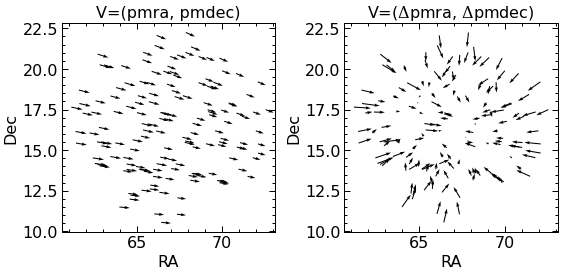

In [35]:
cl0 = kn.Cluster([-6.32, 45.24, 5.30], 0., b0=b0).sample_at(cl.members.truth.g.icrs)
df = cl0.members.truth

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.quiver(df['ra'],df['dec'],df['pmra'],df['pmdec'])
dpmra,dpmdec = df[['pmra','pmdec']].apply(lambda x:x-np.mean(x)).values.T
ra,dec = df[['ra','dec']].values.T
ax2.quiver(ra,dec,dpmra,dpmdec)
for cax in [ax1,ax2]:
    cax.set(xlabel='RA',ylabel='Dec')
ax1.set(title="V=(pmra, pmdec)")
ax2.set(title="V=($\Delta$pmra, $\Delta$pmdec)")
fig.tight_layout()

While the overall proper motion is the same (left plot above) because all stars have the same velocity, in detail, they are projections of the velocity at different positions of the fictitious celestial sphere. So if you take out the mean and look at the residual proper motions (right plot above), the pattern is such that they are converging to a certain direction (ra, dec). This converging point is where the velocity vector becomes exactly radial, and the converging pattern is due to the fact that the cluster is receding from us.

At the specified position (`b0`), the radial direction is more or less aligned with the $y$-axis. So if we reverse the sign of our $y$ velocity and make the cluster to be approaching towards us, the residual proper motion now shows diverging pattern as we see below.

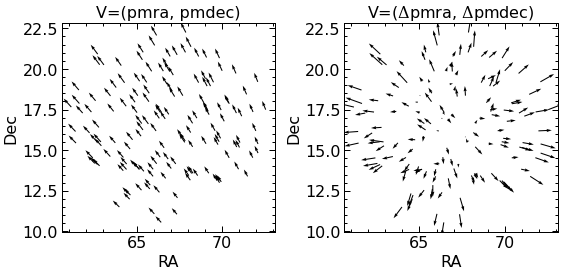

In [36]:
cl0 = kn.Cluster([-6.32, -45.24, 5.30], 0., b0=b0).sample_at(cl.members.truth.g.icrs)
df = cl0.members.truth

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.quiver(df['ra'],df['dec'],df['pmra'],df['pmdec'])
dpmra,dpmdec = df[['pmra','pmdec']].apply(lambda x:x-np.mean(x)).values.T
ra,dec = df[['ra','dec']].values.T
ax2.quiver(ra,dec,dpmra,dpmdec)
for cax in [ax1,ax2]:
    cax.set(xlabel='RA',ylabel='Dec')
ax1.set(title="V=(pmra, pmdec)")
ax2.set(title="V=($\Delta$pmra, $\Delta$pmdec)")
fig.tight_layout()

## Degeneracy between perspective effect and isotropic contraction/expansion

This figure should also make you wonder, what if the cluster is contracting or expanding?
Indeed, if we only have proper motions, we cannot tell the difference between the (istoropic) contractiong/expansion of the cluster and the perspective effect due to radial velocity. We show this below by making another mock cluster that looks the same in terms of their (residual) proper motions but that is actually stationary in the radial direction and instead contracting.

In [165]:
def make_equivalent_cluster(cl):
    '''
    Make a cluster that has zero RV (not receding nor approaching)
    but is either expanding or contracting, resulting it to appear equivalent
    in terms of observed proper motions.
    '''
    import astropy.coordinates as coord
    b0, v0 = cl.b0, cl.v0
    c = coord.ICRS(*(b0*u.pc), *(v0*u.km/u.s),
                   representation_type='cartesian',differential_type='cartesian').spherical
    print(c)
    print(c.differentials['s'])

    v0_rv0 = coord.ICRS(
        c.lon,c.lat,c.distance,c.differentials['s'].d_lon*np.cos(c.lat),
        c.differentials['s'].d_lat).velocity.d_xyz.to(u.km/u.s)

    rv = c.differentials['s'].d_distance
    kappa = rv.to(u.km/u.s).value / c.distance.to(u.pc).value * 1000.0
    print(kappa)

    
    cl_rv0 = (
        kn.Cluster(v0_rv0.value, 0.,
                   b0=b0,T=np.diag([-kappa,-kappa,-kappa]))
        .sample_at(cl.members.truth.g.icrs))
    return cl_rv0

(66.75107646, 16.52048667, 46.77200017) (deg, deg, pc)
(111.32538582, -27.19257586, 38.96591964) (mas / yr, mas / yr, km / s)
833.1035554621004


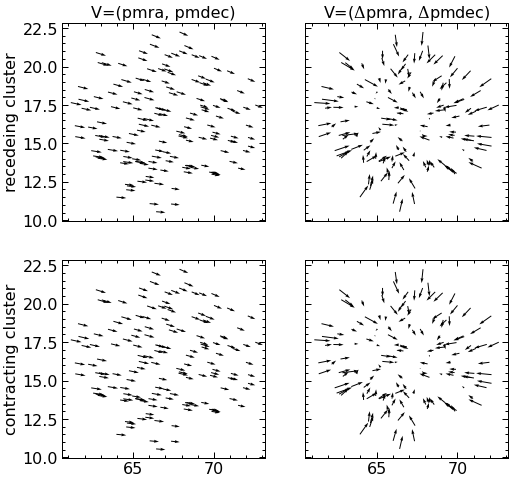

In [170]:
cl0 = kn.Cluster([-6.32, 45.24, 5.30], 0., b0=b0).sample_at(cl.members.truth.g.icrs)
df0 = cl0.members.truth
cl_contracting =make_equivalent_cluster(cl0)
df = cl_contracting.members.truth

fig, ((ax11,ax12),(ax21,ax22)) = plt.subplots(2, 2, figsize=(8,8),sharex=True,sharey=True)

ax11.quiver(df0['ra'],df0['dec'],df0['pmra'],df0['pmdec'])
dpmra,dpmdec = df0[['pmra','pmdec']].apply(lambda x:x-np.mean(x)).values.T
ra,dec = df0[['ra','dec']].values.T
ax12.quiver(ra,dec,dpmra,dpmdec, )


ax21.quiver(df['ra'],df['dec'],df['pmra'],df['pmdec'])
dpmra,dpmdec = df[['pmra','pmdec']].apply(lambda x:x-np.mean(x)).values.T
ra,dec = df[['ra','dec']].values.T
ax22.quiver(ra,dec,dpmra,dpmdec, )
ax11.set(title="V=(pmra, pmdec)")
ax12.set(title="V=($\Delta$pmra, $\Delta$pmdec)")
ax11.set(ylabel="recedeing cluster")
ax21.set(ylabel="contracting cluster");

In [175]:
# check the individual values of stars at the same position are actually the same
assert np.allclose(df['pmra'].values,df0['pmra'].values)
assert np.allclose(df['pmdec'].values,df0['pmdec'].values)

As you can see, in terms of astrometric parameters, the two are indistinguishable. In other words, there is a degeneracy between radial component of the mean velocity and the isotropic expansion/contraction.

However, if we precise radial velocities even for some of these stars, we may hope to break that degeneracy and constrain the internal motion of the cluster.

## Effect of rotation

So what if the cluster is rotating around $z$-axis? What effect would it introduce to the observables?

We can again make another mock cluster sampling the same positions but this time giving it a little rotation of 300 m/s/pc.

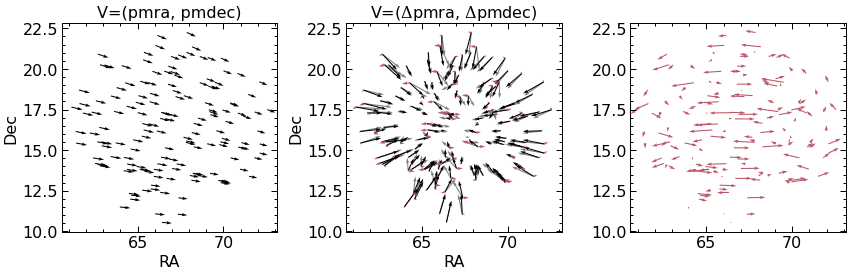

In [190]:
cl0 = kn.Cluster([-6.32, 45.24, 5.30], 0., b0=b0).sample_at(cl.members.truth.g.icrs)
df0 = cl0.members.truth
clrot = kn.Cluster([-6.32, 45.24, 5.30], 0., b0=b0, omegas=[0,0,300.]).sample_at(cl.members.truth.g.icrs)
df = clrot.members.truth

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.quiver(df['ra'],df['dec'],df['pmra'],df['pmdec'])
dpmra0,dpmdec0 = df0[['pmra','pmdec']].apply(lambda x:x-np.mean(x)).values.T
# take out perspective effect exactly
dpmrarot,dpmdecrot = df[['pmra','pmdec']].apply(lambda x:x-np.mean(x)).values.T
dpmrarot1,dpmdecrot1 = (df[['pmra','pmdec']] - df0[['pmra','pmdec']]).values.T

ra,dec = df[['ra','dec']].values.T

ax2.quiver(ra,dec,dpmra0,dpmdec0,scale_units='inches',scale=60, color='gray')
ax2.quiver(ra,dec,dpmrarot,dpmdecrot,scale_units='inches',scale=60, color='k')

ax2.quiver(ra,dec,dpmrarot1,dpmdecrot1,scale_units='inches',scale=60, color='C2')
ax3.quiver(ra,dec,dpmrarot1,dpmdecrot1,scale_units='inches',scale=20, color='C2')

for cax in [ax1,ax2]:
    cax.set(xlabel='RA',ylabel='Dec')
ax1.set(title="V=(pmra, pmdec)")
ax2.set(title="V=($\Delta$pmra, $\Delta$pmdec)")
fig.tight_layout()

In the middle plot, we see that such small rotation will only deflect the residual proper motion slightly from the one without the rotation (perspective effect only; gray arrows) by the little red arrows. In other words, the vector some of gray and red arrows give our observed proper motion (black arrows).

If we separate out the perspective effect and only look at the effect of rotation (the right plot above), we can see the anti-symmetric pattern distinctive of rotation more clearly. The right quiver plot is made with 1/3 scale length of the middle to highlight these small vectors.

It's clear that the relative importance of the perspective effect of the mean velocity versus any internal velocity gradient (shear or rotation) depends on the cluster parameters.